# Knowledge Tracing without Time Information

In [1]:
import itertools
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import os

In [2]:
# MPSでサポートしていない演算を実行する際に、CPUにフォールバックするように設定
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

relu = nn.ReLU()

use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

# torch.manual_seed(0)

if use_cuda:
    device = torch.device("cuda")
# elif use_mps:
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

## FrcSubデータ・DINAモデル

In [17]:
import os
import logging
import numpy as np
from EduCDM import EMDINA as DINA

# ファイルの相対パスを設定
current_dir = os.getcwd()
data_file_path = os.path.join(current_dir, 'FrcSub', 'data.txt')
q_matrix_file_path = os.path.join(current_dir, 'FrcSub', 'q.txt')

# ファイルの存在確認
if not os.path.exists(data_file_path):
    raise FileNotFoundError(f"{data_file_path} not found.")
if not os.path.exists(q_matrix_file_path):
    raise FileNotFoundError(f"{q_matrix_file_path} not found.")

# ファイルの読み込み
response_data = np.loadtxt(data_file_path, dtype=int)  # 学生-問題の回答データ
q_matrix = np.loadtxt(q_matrix_file_path, dtype=int)  # Q行列
print("Q", q_matrix.shape)

# データの形状取得
stu_num, prob_num = response_data.shape
_, know_num = q_matrix.shape

# 回答データをDINA形式に変換
R = -1 * np.ones((stu_num, prob_num))
for stu_id in range(stu_num):
    for prob_id in range(prob_num):
        R[stu_id, prob_id] = response_data[stu_id, prob_id]
print("R", R.shape)

# ログレベルを設定
logging.getLogger().setLevel(logging.INFO)

# DINAモデルの初期化
cdm = DINA(R, q_matrix, stu_num, prob_num, know_num, skip_value=-1)

# モデルの訓練
cdm.train(epoch=10, epsilon=1e-3)  # epochやepsilonは調整可能

# 訓練済みモデルの保存
model_path = os.path.join(current_dir, 'dina_model.params')
cdm.save(model_path)

# モデルの評価 (RMSE, MAE)
rmse, mae = cdm.eval([{'user_id': i, 'item_id': j, 'score': R[i, j]}
                      for i in range(stu_num) for j in range(prob_num) if R[i, j] != -1])
print("RMSE: %.6f, MAE: %.6f" % (rmse, mae))

# 学習済みモデルのパラメータをロード
model_path = "dina_model.params"
cdm.load(model_path)

attributes = []
# 学生ごとのアトリビュート（知識状態）を表示
print("Student Knowledge Attributes:")
for stu_id in range(cdm.stu_num):
    # 学生の状態IDを取得
    state_id = cdm.theta[stu_id]
    # 状態IDに対応する知識状態（バイナリベクトル）
    knowledge_state = cdm.all_states[state_id]
    attributes.append(knowledge_state)
    print(f"Student {stu_id}: State ID = {state_id}, Knowledge State = {knowledge_state}")


Q (20, 8)
(536, 20)
R (536, 20)


INFO:root:save parameters to /Users/nagairyousuke/Documents/kashima_lab/KnowledgeTracing/dina_model.params
evaluating: 100%|██████████| 10720/10720 [00:00<00:00, 1759319.91it/s]
INFO:root:load parameters from dina_model.params


RMSE: 0.293777, MAE: 0.179607
Student Knowledge Attributes:
Student 0: State ID = 239, Knowledge State = [1. 1. 1. 0. 1. 1. 1. 1.]
Student 1: State ID = 251, Knowledge State = [1. 1. 1. 1. 1. 0. 1. 1.]
Student 2: State ID = 210, Knowledge State = [1. 1. 0. 1. 0. 0. 1. 0.]
Student 3: State ID = 127, Knowledge State = [0. 1. 1. 1. 1. 1. 1. 1.]
Student 4: State ID = 3, Knowledge State = [0. 0. 0. 0. 0. 0. 1. 1.]
Student 5: State ID = 2, Knowledge State = [0. 0. 0. 0. 0. 0. 1. 0.]
Student 6: State ID = 64, Knowledge State = [0. 1. 0. 0. 0. 0. 0. 0.]
Student 7: State ID = 0, Knowledge State = [0. 0. 0. 0. 0. 0. 0. 0.]
Student 8: State ID = 64, Knowledge State = [0. 1. 0. 0. 0. 0. 0. 0.]
Student 9: State ID = 64, Knowledge State = [0. 1. 0. 0. 0. 0. 0. 0.]
Student 10: State ID = 215, Knowledge State = [1. 1. 0. 1. 0. 1. 1. 1.]
Student 11: State ID = 223, Knowledge State = [1. 1. 0. 1. 1. 1. 1. 1.]
Student 12: State ID = 3, Knowledge State = [0. 0. 0. 0. 0. 0. 1. 1.]
Student 13: State ID = 0,

In [4]:
attributes = np.array(attributes)
print(attributes)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]]


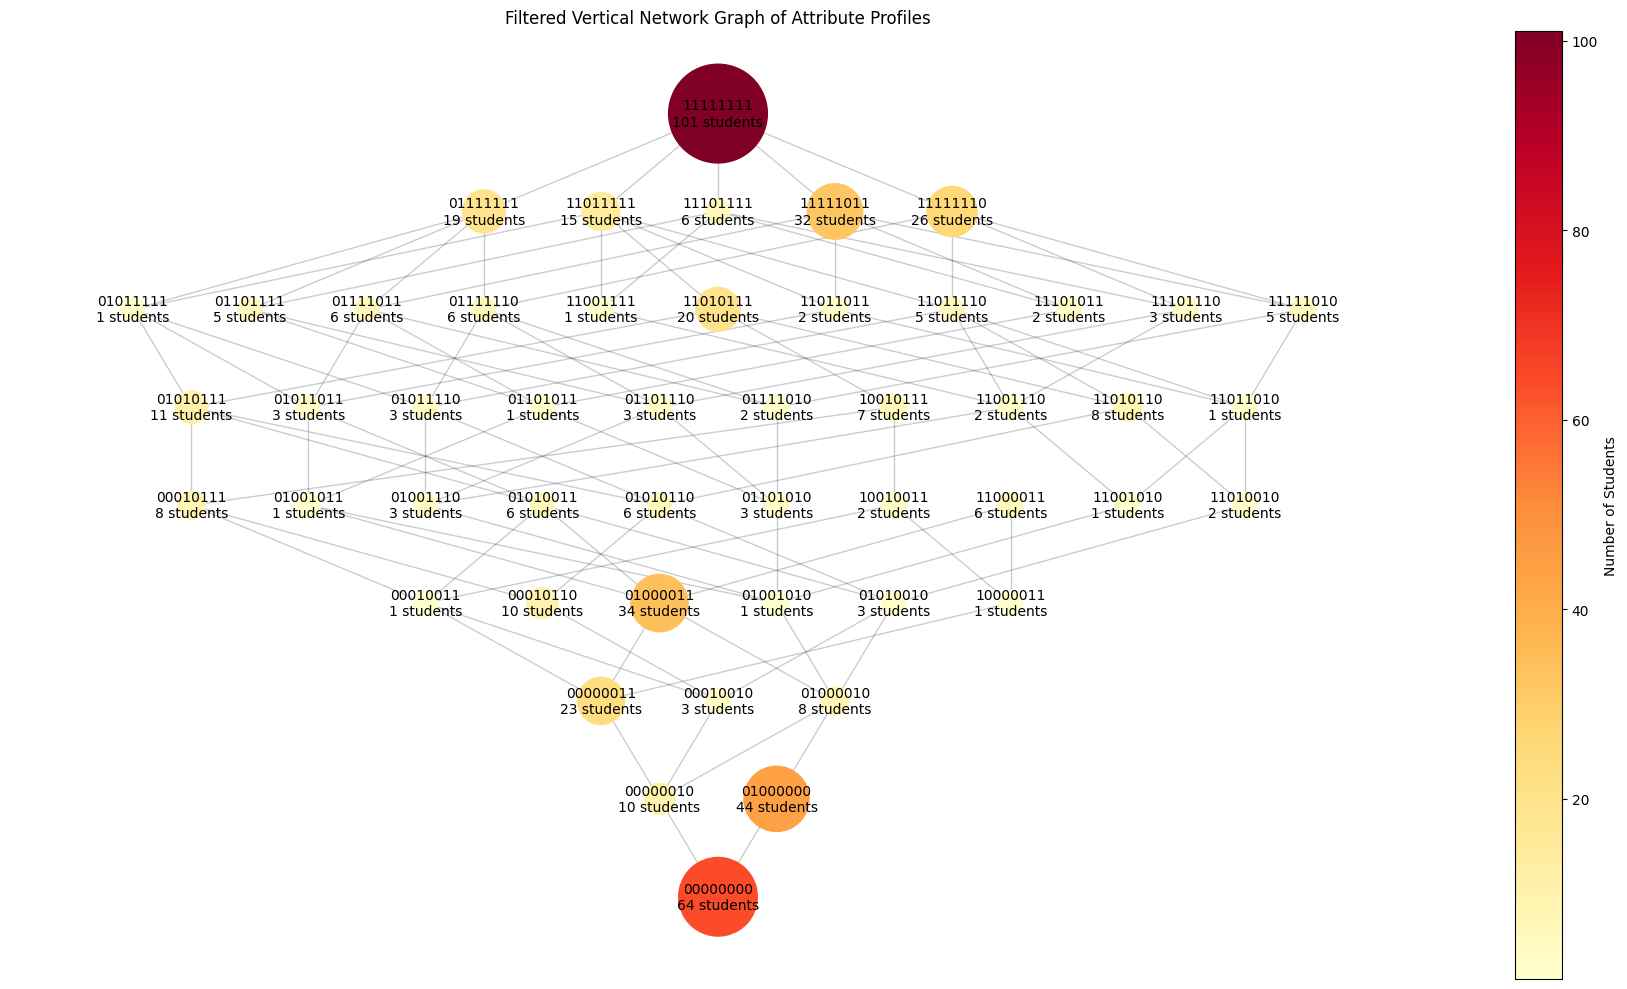

In [5]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# アトリビュート数を取得
num_attributes = attributes.shape[1]

# すべての可能な状態（アトリビュートプロファイル）を生成
states = list(itertools.product([0, 1], repeat=num_attributes))

# 各状態の学生数をカウント
state_counts = defaultdict(int)
for attr in attributes:
    state_counts[tuple(attr)] += 1

# 学生数がゼロの状態を除外
filtered_states = [state for state in states if state_counts[state] > 0]

# グラフ作成
G_filtered = nx.Graph()

# ノードを追加し、学生数を属性として設定
for state in filtered_states:
    G_filtered.add_node(state, count=state_counts[state])

# エッジを追加
for state in filtered_states:
    for i in range(num_attributes):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in filtered_states:
                G_filtered.add_edge(state, next_state)

# カスタムレイアウト
def custom_layout(G, num_attributes):
    pos = {}
    levels = {}
    for state in G.nodes():
        level = sum(state)  # 状態の1の数でレベルを定義
        if level not in levels:
            levels[level] = []
        levels[level].append(state)
    
    # レベルごとにノードを配置
    for level, states_at_level in levels.items():
        num_nodes_at_level = len(states_at_level)
        for i, state in enumerate(sorted(states_at_level)):
            x = i - (num_nodes_at_level - 1) / 2
            y = level
            pos[state] = (x, y)
    return pos

# レイアウトを適用
pos_filtered = custom_layout(G_filtered, num_attributes)

# グラフ設定
plt.figure(figsize=(18, 10))
nx.draw_networkx_edges(G_filtered, pos_filtered, alpha=0.2)

# ノードのサイズと色を学生数に基づいて調整
node_sizes_filtered = [max(300, state_counts[node] * 50) for node in G_filtered.nodes()]
node_colors_filtered = [state_counts[node] for node in G_filtered.nodes()]
nodes_filtered = nx.draw_networkx_nodes(
    G_filtered, pos_filtered, node_size=node_sizes_filtered, node_color=node_colors_filtered, cmap=plt.cm.YlOrRd
)

# ラベルを追加
labels_filtered = {node: f"{''.join(map(str, node))}\n{state_counts[node]} students" for node in G_filtered.nodes()}
nx.draw_networkx_labels(G_filtered, pos_filtered, labels_filtered, font_size=10)

# カラーバーの追加
plt.colorbar(nodes_filtered, label='Number of Students')

# グラフの仕上げ
plt.title('Filtered Vertical Network Graph of Attribute Profiles')
plt.axis('off')
plt.tight_layout()
plt.show()

## モデル構築

In [6]:
def _bcsoftmax1d_stable(x, budget):
    """Budget Constrained Softmax function for vector.
    This function is more numerically stable than `_bcsoftmax1d` by computing some values in log-scale.
    
    Args:
        x (Tensor): input vector. shape: (n_outputs, )
        budget (Tensor): budget (constraint) vector. shape: (n_outputs, )

    Returns:
        y (Tensor): output probability vector. shape: (n_outputs, ). Satisfying the constraints y_i <= budget_i.
    
    """
    # sorting
    _, indices = torch.sort(torch.log(budget) - x, descending=False)
    x = x[indices]
    budget = budget[indices]
    # find K_B
    log_r = torch.flip(torch.logcumsumexp(torch.flip(x, dims=(0, )), dim=0), dims=(0, ))
    s = 1.0 - (torch.cumsum(budget, dim=0) - budget)
    is_in_KB = torch.logical_or(
        budget == 0,
        torch.logical_and(
            s - budget > 0,
            x - log_r + torch.log(s) > torch.log(budget)
        )
    )
    # compute outputs
    exp_x = torch.exp(x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0])
    s = 1 - torch.sum(budget * is_in_KB)
    r = torch.sum(exp_x * (~is_in_KB))
    y = torch.where(~is_in_KB, s * exp_x / r, budget)
    # undo sorting
    _, inv_indices = torch.sort(indices, descending=False)
    return y[inv_indices]


class BCSoftmax1d(torch.autograd.Function):
    """Autograd implementation of Budget Constrained Softmax function for vector.
    """
    generate_vmap_rule = True
    
    @staticmethod
    def forward(x, c):
        y = _bcsoftmax1d_stable(x, c)
        return y

    @staticmethod
    def setup_context(ctx, inputs, output):
        x, c = inputs
        is_in_KB = c == output
        ctx.save_for_backward(x, c, is_in_KB)
    
    @staticmethod
    def backward(ctx, grad_y):
        x, c, is_in_KB = ctx.saved_tensors
        exp_x = torch.exp(
            x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0]
        )
        s = 1 - torch.sum(c * is_in_KB)
        r = torch.sum(exp_x * (~is_in_KB))
        
        # compute Jacobian
        Jx = torch.where(
            torch.outer(~is_in_KB, ~is_in_KB),
            torch.diag(~is_in_KB * exp_x) * r - torch.outer(exp_x, exp_x),
            0,
        )
        Jx *= torch.where(
            s > 0,
            s / (r * r),
            0
        )
        Jc = torch.where(
            torch.outer(~is_in_KB, is_in_KB),
            - exp_x[:, None] / r,
            1.0 * torch.diag(is_in_KB)
        )

        # return vector-Jacobian product
        return torch.matmul(grad_y, Jx), torch.matmul(grad_y, Jc)

In [7]:
bcsoftmax1d = BCSoftmax1d.apply

# バッチを処理するとき
# bcsoftmax2d = torch.vmap(BCSoftmax1d.apply) # input shape = (batch_size, n_classes)

class Model(nn.Module):
    def __init__(self, num_components):
        super(Model, self).__init__()
        self.fc = nn.Linear(num_components, num_components)  # 全結合層

    def forward(self, x, c):
        x = self.fc(x)  # 全結合層の適用
        x = bcsoftmax1d(x, c)
        return x

In [8]:
def train(model, num_components, device, train_X, train_Y, criterion, optimizer, epoch, hyp, reg):
    model.train()
    data, targets = train_X.to(device), train_Y.to(device)
    optimizer.zero_grad()

    outputs = []
    relu = nn.ReLU()
    # データによってループ回数が異なる
    for i, target in enumerate(targets):
        # 初期budget
        # デバイスに転送
        c = torch.ones(num_components, dtype=torch.float32, device=device).to(device)
        state = data[i].to(device)

        for _ in range(int(sum(target))):
            # もしcの和が1なら、rが0となってしまう
            if c.sum() <= 1:
                prob = c
            else:
                prob = model(state, c)  # 状態から遷移確率を計算
            state = prob + state  # 状態の更新

            c = relu(c - prob)  # 予算の更新

        outputs.append(state - data[i])  # 最終的な出力を保存
    
    outputs = torch.stack(outputs)

    # 正則化項
    loss_o = criterion(outputs, targets)
    if reg == 'L1':
        loss = loss_o + hyp * l1(model)
    elif reg == 'L2':
        loss = loss_o + hyp * l2(model)
    else:
        loss = loss_o

    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')
    return float(loss)


def val_loss(model, num_components, device, val_X, val_Y, criterion, hyp, reg):
    model.eval()
    data, targets = val_X.to(device), val_Y.to(device)
    relu = nn.ReLU()

    with torch.no_grad():
        val_outputs = []
        for i, target in enumerate(targets):
            c = torch.ones(num_components, dtype=torch.float32, device=device).to(device)
            state = data[i].to(device)
            for _ in range(int(sum(target))):
                # もしcの和が1なら、rが0となってしまう
                if c.sum() <= 1:
                    prob = c
                else:
                    prob = model(state, c)  # 状態から遷移確率を計算
                state = prob + state  # 状態の更新
                c = relu(c - prob)  # 予算の更新

            val_outputs.append(state - data[i])

        val_outputs = torch.stack(val_outputs)

        # 正則化項
        loss_o = criterion(val_outputs, targets)
        if reg == 'L1':
            loss = loss_o + hyp * l1(model)
        elif reg == 'L2':
            loss = loss_o + hyp * l2(model)
        else:
            loss = loss_o
    return float(loss)

def l1(model):
    l1_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l1_reg = l1_reg + torch.sum(torch.abs(param))
    return l1_reg

def l2(model):
    l2_reg = torch.tensor(0., requires_grad=True)
    for param in model.named_parameters():
        l2_reg = l2_reg + torch.sum(torch.pow(param, 2))
    return l2_reg

In [9]:
# データをトレーニングと検証に分割（正解数のバランスが良くなるように分割）
# 8:2に分割
def split_balanced_data(train_X, train_Y, ratio=0.8):
    data_per_correct_count = defaultdict(list)
    for x, y in zip(train_X, train_Y):
        correct_count = sum(y)
        data_per_correct_count[correct_count].append((x, y))

    train_X_data, train_Y_data, val_X_data, val_Y_data = [], [], [], []
    for correct_count, data in data_per_correct_count.items():
        split_index = int(len(data) * ratio)
        train_data = data[:split_index]
        val_data = data[split_index:]
        train_X_data.extend([x for x, y in train_data])
        train_Y_data.extend([y for x, y in train_data])
        val_X_data.extend([x for x, y in val_data])
        val_Y_data.extend([y for x, y in val_data])

    return train_X_data, train_Y_data, val_X_data, val_Y_data

In [10]:
import argparse

parser = argparse.ArgumentParser()

# 要素（問題）数・依存行列の種類。実験回数
parser.add_argument('--component_size', type=int  , default=8    , help='number of components')
parser.add_argument('--num_paterns'   , type=int  , default=1    , help='number of patterns')
parser.add_argument('--trials'        , type=int  , default=1    , help='number of trials')

# 学習
parser.add_argument('--epochs'        , type=int  , default=1500 , help='number of epochs')
parser.add_argument('--lr'            , type=float, default=0.01 , help='learning rate')
parser.add_argument('--early_stopping', type=int  , default=10   , help='number of epochs for early stopping')

# データ生成
parser.add_argument('--split_ratio'   , type=float, default=0.8  , help='split ratio of training and validation data')
parser.add_argument('--num_stepdata'  , type=int  , default=40   , help='number of data per step')
parser.add_argument('--all_path'      , type=bool , default=False, help='use all path or not')

# 正則化
parser.add_argument('--Regularization', type=str  , default='L1' , help='Regularization, L1 or L2 or None')
parser.add_argument('--hyperparameter', type=float, default=0.001, help='hyperparameter for regularization')



_StoreAction(option_strings=['--hyperparameter'], dest='hyperparameter', nargs=None, const=None, default=0.001, type=<class 'float'>, choices=None, help='hyperparameter for regularization', metavar=None)

In [11]:
# テスト用のダミー引数
args, unknown = parser.parse_known_args()
print('args:', args)

args: Namespace(component_size=8, num_paterns=1, trials=1, epochs=1500, lr=0.01, early_stopping=10, split_ratio=0.8, num_stepdata=40, all_path=False, Regularization='L1', hyperparameter=0.001)


## データ生成

## 評価指標

### KL Divergence

$$ D_{\text{KL}}(p \| q) = \sum_{i} p(i) \log \frac{p(i)}{q(i)} $$

---

### Hellinger距離

$$ H(p, q) = \frac{1}{\sqrt{2}} \left\| \sqrt{p} - \sqrt{q} \right\|_2 $$

$$ \left\| \sqrt{p} - \sqrt{q} \right\|_2 = \sqrt{\sum_{i} \left( \sqrt{p(i)} - \sqrt{q(i)} \right)^2} $$

---

### Jensen-Shannon Divergence

$$ D_{\text{JS}}(p \| q) = \frac{1}{2} D_{\text{KL}}(p \| m) + \frac{1}{2} D_{\text{KL}}(q \| m) $$

$$ m = \frac{1}{2}(p + q) $$

In [12]:
def kl_divergence(p, q, epsilon=1e-10):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # pとqにスムージングを適用
    p = np.where(p == 0, epsilon, p)
    q = np.where(q == 0, epsilon, q)
    
    # KLダイバージェンスの計算
    return np.sum(p * np.log(p / q))

def hellinger_distance(p, q):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    # Hellinger距離の計算式: H(p, q) = (1/√2) * ||√p - √q||_2
    sqrt_p = np.sqrt(p)
    sqrt_q = np.sqrt(q)
    distance = np.sqrt(np.sum((sqrt_p - sqrt_q) ** 2)) / np.sqrt(2)
    return np.mean(distance)

def js_divergence(p, q):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    m = 0.5 * (p + q)
    jsd = 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))
    
    # 各サンプルの平均を返す
    return np.mean(jsd)

In [13]:
# def evaluate(model, num_components, states, comparison = True):
#     model.eval()

#     node_probabilities = defaultdict(float)
#     start = tuple(0 for _ in range(num_components))
#     node_probabilities[start] = 1

#     KL, HD, JSD = 0, 0, 0
#     c_KL, c_HD, c_JSD = 0, 0, 0

#     for state in states:
#         if state == (1,) * (num_components):  # 最後のノードでは遷移がないのでスキップ
#             continue

#         probabilities = calculate_transition_probabilities(A, np.array(state))

#         # 比較手法
#         c_pred = []
#         total = 0

#         # 最下層から頂点までのノードの分布を順に計算
#         for i in range(num_components):
#             if state[i] == 0:  # 未習得
#                 # 遷移後の状態
#                 next_state = list(state)
#                 next_state[i] = 1
#                 next_state = tuple(next_state)
#                 node_probabilities[next_state] += probabilities[i] * node_probabilities[state]

#                 c_pred.append(state_counts[next_state])
#                 total += state_counts[next_state]
#             else:
#                 c_pred.append(0)
        
#         # budget
#         c_g = torch.ones(num_components, dtype=torch.float32)
#         c_g = relu(c_g - torch.tensor(state, dtype=torch.float32))

#         # 状態とその予測分布
#         state_tensor = torch.tensor(state, dtype=torch.float32)
#         predicted_values = model(state_tensor, c_g) # 予測値を計算

#         # 評価指標の計算
#         KL += node_probabilities[state] * kl_divergence(probabilities, predicted_values.detach())
#         HD += node_probabilities[state] * hellinger_distance(probabilities, predicted_values.detach())
#         JSD += node_probabilities[state] * js_divergence(probabilities, predicted_values.detach())

        
#         # 比較手法
#         if total > 0:
#             c_pred = np.array(c_pred) / total
        
#         c_KL += node_probabilities[state] * kl_divergence(probabilities, c_pred)
#         c_HD += node_probabilities[state] * hellinger_distance(probabilities, c_pred)
#         c_JSD += node_probabilities[state] * js_divergence(probabilities, c_pred)
    
#     if comparison:
#         # 最終的な値をPythonのfloatにキャストする
#         return float(KL), float(HD), float(JSD), float(c_KL), float(c_HD), float(c_JSD)
#     else:
#         return float(KL), float(HD), float(JSD)


In [14]:
import csv
from datetime import datetime

today = datetime.now().strftime("%Y-%m-%d")

# ファイル名に日付を含める
results_csv = f"{today}_{args}_FrcSub_DINA.csv"

comparison = True

# 初回にヘッダーを追加する
if comparison:
    header = [
    "Iteration", 
    "KL_提案手法",
    "HD_提案手法",
    "JSD_提案手法",
    "KL_比較手法",
    "HD_比較手法",
    "JSD_比較手法"
]
else:
    header = [
    "Iteration", 
    "KL",
    "HD",
    "JSD"
]

try:
    with open(results_csv, "x", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(header)
except FileExistsError:
    pass  # ファイルが既に存在する場合は何もしない

In [15]:
# for _ in range(10):
#     A, num_components = dependency_matrix(args.component_size)
#     print(A)

## 学習

In [16]:

for trial in range(args.trials):
    print(f"Trial: {trial+1}")

    num_components = args.component_size
    # データ生成
    X_init = np.array([0] * num_components)
    n_s = len(attributes)
    print("n_components", num_components)
    print("n_s", n_s)
    data_X = [[0] * num_components for _ in range(n_s)]
    data_Y = attributes

    train_X_data, train_Y_data, val_X_data, val_Y_data = split_balanced_data(data_X, data_Y, args.split_ratio)

    # PyTorch テンソルに変換
    train_X = torch.tensor(train_X_data, dtype=torch.float32)
    train_Y = torch.tensor(train_Y_data, dtype=torch.float32)
    val_X = torch.tensor(val_X_data, dtype=torch.float32)
    val_Y = torch.tensor(val_Y_data, dtype=torch.float32)

    print(f"Train data: {len(train_X)}, Validation data: {len(val_X)}")
    print(f"Train X: {train_X.shape}, Train Y: {train_Y.shape}")
    
    "状態定義"
    states = [state for state in itertools.product([0, 1], repeat=num_components)]
    states = sorted(states, key=lambda state: sum(state))

    # 状態ごとの学生数をカウント
    state_counts = defaultdict(int)
    for i in range(len(train_X)):
        state_tuple = tuple(map(int, train_X[i] + train_Y[i]))
        state_counts[state_tuple] += 1

    print(state_counts)

    "モデル定義"
    # モデル、損失関数、最適化関数の設定
    model = Model(num_components)  # 要素数+初期状態
    criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    model = model.to(device)

    # ロスの初期化
    best_val_loss = float('inf')
    valid_loss_min = float('inf')
    early_stopping_count = 0

    # 試行ごとのロス値を記録するリスト
    training_losses = []
    validation_losses = []
    
    for epoch in range(args.epochs):
        train_loss = train(model, num_components, device, train_X, train_Y, criterion, optimizer, epoch, args.hyperparameter, args.Regularization)
        valid_loss = val_loss(model, num_components, device, val_X, val_Y, criterion, args.hyperparameter, args.Regularization)
        valid_loss_min = min(valid_loss_min, valid_loss)
        
        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

        if valid_loss_min < valid_loss:
            early_stopping_count += 1
        else:
            early_stopping_count = 0
            # torch.save(model.state_dict(), f"{args}_{lr}_{traial}.pth")
            
        if early_stopping_count >= args.early_stopping:
            print(f"Early stopping at epoch {epoch}")
            break

    print(f"Best validation loss: {valid_loss_min}")

    # eval_results = evaluate(model, num_components, states, comparison)
    # # 試行ごとの指標をCSVに追記
    # with open(results_csv, "a", newline="") as file:
    #     writer = csv.writer(file)
    #     writer.writerow([
    #         trial + 1,
    #         *eval_results
    #     ])

Trial: 1
n_components 8
n_s 536
Train data: 425, Validation data: 111
Train X: torch.Size([425, 8]), Train Y: torch.Size([425, 8])
defaultdict(<class 'int'>, {(1, 1, 1, 0, 1, 1, 1, 1): 6, (1, 1, 1, 1, 1, 0, 1, 1): 27, (0, 1, 1, 1, 1, 1, 1, 1): 13, (1, 1, 0, 1, 1, 1, 1, 1): 10, (1, 1, 1, 1, 1, 1, 1, 0): 22, (1, 1, 0, 1, 0, 0, 1, 0): 2, (0, 1, 1, 0, 1, 0, 1, 0): 3, (0, 1, 0, 0, 1, 1, 1, 0): 2, (1, 0, 0, 1, 0, 0, 1, 1): 2, (1, 1, 0, 0, 0, 0, 1, 1): 5, (0, 0, 0, 1, 0, 1, 1, 1): 7, (0, 1, 0, 0, 1, 0, 1, 1): 1, (0, 1, 0, 1, 0, 1, 1, 0): 4, (0, 1, 0, 1, 0, 0, 1, 1): 4, (0, 0, 0, 0, 0, 0, 1, 1): 18, (0, 0, 0, 1, 0, 0, 1, 0): 3, (0, 1, 0, 0, 0, 0, 1, 0): 6, (0, 0, 0, 0, 0, 0, 1, 0): 9, (0, 1, 0, 0, 0, 0, 0, 0): 34, (0, 0, 0, 0, 0, 0, 0, 0): 51, (1, 1, 0, 1, 0, 1, 1, 1): 11, (1, 1, 1, 0, 1, 1, 1, 0): 3, (1, 1, 1, 0, 1, 0, 1, 1): 2, (1, 1, 0, 1, 1, 1, 1, 0): 4, (0, 1, 1, 0, 1, 1, 1, 1): 5, (1, 1, 0, 1, 1, 0, 1, 1): 2, (0, 1, 1, 1, 1, 0, 1, 1): 5, (0, 1, 1, 1, 1, 1, 1, 0): 6, (1, 1, 0, 0, 1, 1, 1,

/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_80576/2457092647.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  train_Y = torch.tensor(train_Y_data, dtype=torch.float32)


KeyboardInterrupt: 

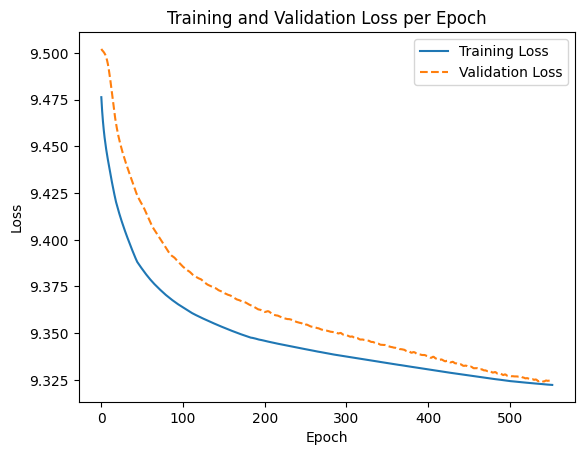

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

In [21]:
torch.set_printoptions(precision=4, sci_mode=False)# モデルの各パラメータを表示
for param in model.parameters():
    print("a", param)

a Parameter containing:
tensor([[     0.0014,     -0.0097,     -0.0005,      1.4663,      0.0022,
              0.0008,     -0.0062,      0.0004],
        [    -0.0003,     -2.5811,     -0.0006,     -0.0023,      0.0005,
              0.0019,      0.0100,     -0.0011],
        [     0.0022,     -0.0322,      0.0032,      2.3884,      1.0978,
              0.0015,     -1.0514,      0.0001],
        [    -0.0058,      0.0027,      0.0003,     -0.8268,      0.0000,
             -0.0012,      0.3028,     -0.0007],
        [     0.0008,     -0.0033,      0.0041,      1.6658,      0.0029,
              0.0114,     -0.0021,      0.0132],
        [    -0.0019,      0.0006,     -0.0012,     -0.8860,     -0.1370,
             -0.0001,     -0.0029,     -0.0007],
        [    -0.0001,      2.6781,      0.0000,      0.0005,     -0.0003,
              0.0004,      0.8834,      0.0005],
        [    -0.0010,      0.0451,     -0.0018,     -2.1819,      0.0042,
             -0.5475,      0.0491,     -1

## 図示

tensor([1., 1., 1., 1., 1., 1., 1., 1.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.]])
tensor(0.)
State: (0, 0, 0, 0, 0, 0, 0, 0), Predicted Values: tensor([0.0036, 0.8121, 0.0033, 0.0136, 0.0041, 0.0119, 0.1214, 0.0300],
       grad_fn=<BCSoftmax1dBackward>)
tensor([1., 1., 1., 1., 1., 1., 1., 0.])
tensor([[0., 0., 0., 0., 0., 0., 0., 1.]])
tensor(0.)
State: (0, 0, 0, 0, 0, 0, 0, 1), Predicted Values: tensor([0.0037, 0.8370, 0.0034, 0.0140, 0.0043, 0.0123, 0.1253, 0.0000],
       grad_fn=<BCSoftmax1dBackward>)
tensor([1., 1., 1., 1., 1., 1., 0., 1.])
tensor([[0., 0., 0., 0., 0., 0., 1., 0.]])
tensor(0.)
State: (0, 0, 0, 0, 0, 0, 1, 0), Predicted Values: tensor([0.0040, 0.9208, 0.0013, 0.0206, 0.0046, 0.0134, 0.0000, 0.0354],
       grad_fn=<BCSoftmax1dBackward>)
tensor([1., 1., 1., 1., 1., 0., 1., 1.])
tensor([[0., 0., 0., 0., 0., 1., 0., 0.]])
tensor(0.)
State: (0, 0, 0, 0, 0, 1, 0, 0), Predicted Values: tensor([0.0037, 0.8328, 0.0034, 0.0139, 0.0042, 0.0000, 0.1243, 0.0178],
       gra

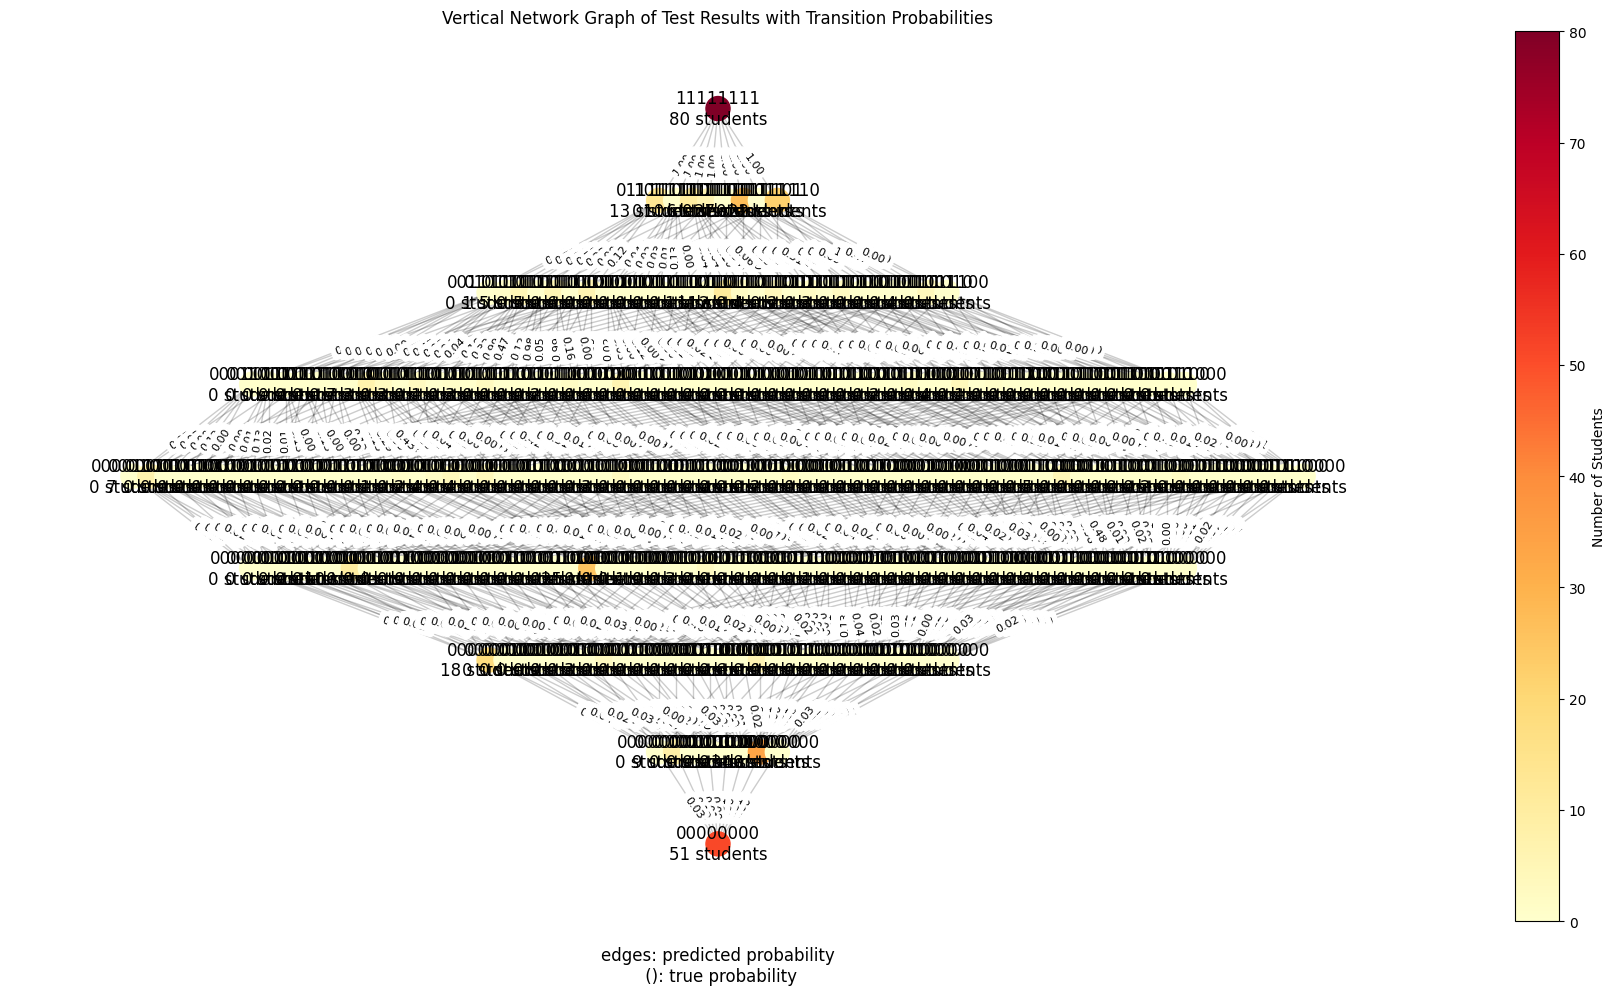

State counts:
State 00000000: 51 students
State 00000010: 9 students
State 01000000: 34 students
State 00000001: 0 students
State 00000100: 0 students
State 00001000: 0 students
State 00010000: 0 students
State 00100000: 0 students
State 10000000: 0 students
State 00000011: 18 students
State 00010010: 3 students
State 01000010: 6 students
State 00000101: 0 students
State 00000110: 0 students
State 00001001: 0 students
State 00001010: 0 students
State 00001100: 0 students
State 00010001: 0 students
State 00010100: 0 students
State 00011000: 0 students
State 00100001: 0 students
State 00100010: 0 students
State 00100100: 0 students
State 00101000: 0 students
State 00110000: 0 students
State 01000001: 0 students
State 01000100: 0 students
State 01001000: 0 students
State 01010000: 0 students
State 01100000: 0 students
State 10000001: 0 students
State 10000010: 0 students
State 10000100: 0 students
State 10001000: 0 students
State 10010000: 0 students
State 10100000: 0 students
State 11000

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
G = nx.Graph()

# Add nodes with the 'count' attribute
for state in states:
    G.add_node(state, count=state_counts[state])

# Add edges between states
for state in states:
    for i in range(num_components):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                G.add_edge(state, next_state)

# Custom layout function with uniform horizontal placement and centered nodes
def custom_layout(G, num_components):
    pos = {}
    # Group nodes by their level (number of 1's in the state)
    levels = {}
    for state in G.nodes():
        level = sum(state)  # Level is the number of 1's in the state
        if level not in levels:
            levels[level] = []
        levels[level].append(state)
    
    # Determine the x and y positions for each node
    for level, states_at_level in levels.items():
        num_nodes_at_level = len(states_at_level)
        for i, state in enumerate(sorted(states_at_level)):
            # x position is evenly spaced horizontally for each level
            x = i - (num_nodes_at_level - 1) / 2  # Center horizontally
            y = level  # y position is the level itself (number of 1's)
            pos[state] = (x, y)
    
    return pos


# Apply the custom layout
pos = custom_layout(G, num_components)

# Normalize x positions
x_values = [pos[node][0] for node in pos]
min_x, max_x = min(x_values), max(x_values)
for node in pos:
    x, y = pos[node]
    x_norm = (x - min_x) / (max_x - min_x)
    pos[node] = (x_norm, y)

# Plot settings
plt.figure(figsize=(18, 10))  # Adjust the figure size as needed

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Adjust node sizes according to the number of students
node_sizes = []
for node in G.nodes():
    count = G.nodes[node]['count']
    size = max(300, min(6000, count/4))  # Increase the minimum size to 600
    node_sizes.append(size)


# Node colors based on the number of students
node_colors = [G.nodes[node]['count'] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.YlOrRd
)

# Create labels including the student counts
labels = {
    node: f"{''.join(map(str, node))}\n{G.nodes[node]['count']} students"
    for node in G.nodes()
}

# Transition probabilities: add labels to edges, including predicted values
edge_labels = {}
for state in states:
    if state == (1,) * (num_components):  # 最後のノードでは遷移がないのでスキップ
        continue
    
    # probabilities = calculate_transition_probabilities(A, np.array(state))
    c_g = torch.ones(num_components, dtype=torch.float32)
    c_g = c_g - torch.tensor(state, dtype=torch.float32)  # 予算を更新
    print(c_g)
    print(torch.tensor([state], dtype=torch.float32))
    state_tensor = torch.tensor(state, dtype=torch.float32)
    print(state_tensor[1])
    predicted_values = model(state_tensor, c_g)  # 予測値を計算
    print(f"State: {state}, Predicted Values: {predicted_values}")

    for i in range(num_components):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                # 遷移確率と予測値をラベルに追加
                # transition_probability = f"({probabilities[i]:.2f})"
                predicted_value = f"{predicted_values[i]:.2f}"  # 予測値を表示
                edge_labels[(state, next_state)] = f"{predicted_value}"


# Draw node labels
nx.draw_networkx_labels(G, pos, labels, font_size=12)
# Draw edge labels with transition probabilities
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.6)

# カラーバーの追加
plt.colorbar(nodes, label='Number of Students')

# グラフ描画の最後にコメントを追加
plt.text(
    0.5, -0.05,  # テキストの位置 (x, y)。x=0.5 は中央、y=1.05 はグラフの上
    "edges: predicted probability\n (): true probability",  # 表示したいテキスト
    horizontalalignment='center',  # テキストの水平方向の配置（中央揃え）
    verticalalignment='center',    # テキストの垂直方向の配置（中央揃え）
    transform=plt.gca().transAxes,  # Axes の座標系で位置を指定 (0-1の範囲)
    fontsize=12,                    # フォントサイズ
    color="black"                   # テキストの色
)

plt.title('Vertical Network Graph of Test Results with Transition Probabilities')
plt.axis('off')
plt.tight_layout()

# Display the graph
plt.show()

# Print the state counts
print("State counts:")
for state, count in sorted(state_counts.items(), key=lambda x: sum(x[0])):
    print(f"State {''.join(map(str, state))}: {count} students")